# **Course**: Deep Learning

[<img align="right" width="400" height="100" src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg">](https://www.tu-braunschweig.de/en/)

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) \([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de)) and [Pedro Achanccaray](https://www.tu-braunschweig.de/en/igp/staff/pedro-diaz) (p.diaz@tu-bs.de)

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  
[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp)

# **Assignment 04:** Improving CNN for EuroSAT dataset

## **Load packages and data**

In [1]:
!pip install wandb

In [2]:
!wandb login e0889b0251f131d15192dcbea2f1400c34a44bff

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Disha\.netrc


In [3]:
# Management of files
import os
from os.path import exists, join

# Tensorflow and Keras
from tensorflow.keras.callbacks import ModelCheckpoint, \
                                       EarlyStopping

# Monitor training
import wandb
from wandb.keras import WandbMetricsLogger

# Working with arrays
import numpy as np

# External files with functions to load the dataset,
# create a CNN model, and a data generator.
from importlib import reload
import datasets
import models
import data_generator
# Useful to reload modified external files without need
# of restarting the kernel. Just run again this cell.
reload(datasets)
reload(models)
reload(data_generator)

from datasets import *
from models import *
from data_generator import *

**Variables**

In [4]:
PROJECT_DIR = "." # os.getcwd()
SEED = 42
BATCH_SIZE = 32
TARGET_SIZE = 64

### **Download the dataset**

We will use the [EuroSAT dataset](https://zenodo.org/record/7711810#.ZFn-y3bP1D9) with Sentinel-2 images. There are two versions of this dataset: RGB (3 bands) and MS (multispectral - 13 bands).

For this assignment, we will work with the RGB version. The following lines download the dataset (~130 MB):

In [5]:
url_dataset = "https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip?download=1"
filename = "EuroSAT_RGB.zip"

if not exists("EuroSAT_RGB"):
  !pip install wget
  import wget
  f = wget.download(url_dataset, PROJECT_DIR)
  import zipfile
  with zipfile.ZipFile(filename, "r") as zip_ref:
    zip_ref.extractall(".")
  os.remove(join(PROJECT_DIR, filename))

### **Reading the dataset**

The function **`read_eurosat`** is implemented in the **`datasets.py`** file. The output of this function are a dataframe with information about the image paths and their corresponding classes, and the number of classes.

In [6]:
path_data = join(PROJECT_DIR, "EuroSAT_RGB")

df, n_classes = read_eurosat(path_data=path_data, SEED=SEED)
classes = np.unique(df["class_str"].values)

df

,path_image,class_str,class_int
0,.\EuroSAT_RGB\Forest\Forest_2313.jpg,Forest,1
1,.\EuroSAT_RGB\PermanentCrop\PermanentCrop_2358...,PermanentCrop,6
2,.\EuroSAT_RGB\HerbaceousVegetation\HerbaceousV...,HerbaceousVegetation,2
3,.\EuroSAT_RGB\Pasture\Pasture_1415.jpg,Pasture,5
4,.\EuroSAT_RGB\Highway\Highway_1611.jpg,Highway,3
...,...,...,...
26995,.\EuroSAT_RGB\River\River_76.jpg,River,8
26996,.\EuroSAT_RGB\Forest\Forest_2391.jpg,Forest,1
26997,.\EuroSAT_RGB\AnnualCrop\AnnualCrop_861.jpg,AnnualCrop,0
26998,.\EuroSAT_RGB\Pasture\Pasture_1796.jpg,Pasture,5


### **Train, Validation and Test sets**

Create **three disjoint** sets: `train`, `validation` and `test`.

Use the following proportions:
- `train`: 60%
- `validation`: 20%
- `test`: 20%

Remember to use **stratified sampling** and the given `SEED` for the splits.

For this, **complete the implementation** of the function **`train_val_test_split`** in the file **`datasets.py`**.

_Search for the **`TODO:`** comments in the file._


In [7]:
splits = train_val_test_split(df,
                              val_size=0.2,
                              test_size=0.2,
                              SEED=SEED)

x_train = splits["x_train"]
y_train = splits["y_train"]
x_val = splits["x_val"]
y_val = splits["y_val"]
x_test = splits["x_test"]
y_test = splits["y_test"]

#### **Class distribution**

For **sanity check**, verify the **class distribution** of each set: `train`, `validation` and `test`.

In [8]:
# Number of samples per class
_, counts_train = np.unique(y_train, return_counts=True)
_, counts_val = np.unique(y_val, return_counts=True)
_, counts_test = np.unique(y_test, return_counts=True)

print("Samples per class - train: {}".format(counts_train))
print("Samples per class - val: {}".format(counts_val))
print("Samples per class - test: {}".format(counts_test))

Samples per class - train: [1800 1800 1800 1500 1500 1200 1500 1800 1500 1800]
Samples per class - val: [600 600 600 500 500 400 500 600 500 600]
Samples per class - test: [600 600 600 500 500 400 500 600 500 600]


## **Data generator**

Go to the file **`data_generator.py`** and **complete the implementation** of the data generator.

_Search for the **`TODO:`** comments in the file._

In [9]:
data_gen_train = DataGenerator(path_images=x_train,
                               labels=y_train,
                               batch_size=BATCH_SIZE,
                               n_classes=n_classes,
                               target_size=TARGET_SIZE,
                               shuffle=True)

data_gen_val = DataGenerator(path_images=x_val,
                             labels=y_val,
                             batch_size=BATCH_SIZE,
                             n_classes=n_classes,
                             target_size=TARGET_SIZE,
                             shuffle=False)

# For sanity check, let's see the generator's output
for i, (x, y) in enumerate(data_gen_train):
    print(i, x.shape, y.shape)

0 (32, 64, 64, 3) (32, 10)
1 (32, 64, 64, 3) (32, 10)
2 (32, 64, 64, 3) (32, 10)
3 (32, 64, 64, 3) (32, 10)
4 (32, 64, 64, 3) (32, 10)
5 (32, 64, 64, 3) (32, 10)
6 (32, 64, 64, 3) (32, 10)
7 (32, 64, 64, 3) (32, 10)
8 (32, 64, 64, 3) (32, 10)
9 (32, 64, 64, 3) (32, 10)
10 (32, 64, 64, 3) (32, 10)
11 (32, 64, 64, 3) (32, 10)
12 (32, 64, 64, 3) (32, 10)
13 (32, 64, 64, 3) (32, 10)
14 (32, 64, 64, 3) (32, 10)
15 (32, 64, 64, 3) (32, 10)
16 (32, 64, 64, 3) (32, 10)
17 (32, 64, 64, 3) (32, 10)
18 (32, 64, 64, 3) (32, 10)
19 (32, 64, 64, 3) (32, 10)
20 (32, 64, 64, 3) (32, 10)
21 (32, 64, 64, 3) (32, 10)
22 (32, 64, 64, 3) (32, 10)
23 (32, 64, 64, 3) (32, 10)
24 (32, 64, 64, 3) (32, 10)
25 (32, 64, 64, 3) (32, 10)
26 (32, 64, 64, 3) (32, 10)
27 (32, 64, 64, 3) (32, 10)
28 (32, 64, 64, 3) (32, 10)
29 (32, 64, 64, 3) (32, 10)
30 (32, 64, 64, 3) (32, 10)
31 (32, 64, 64, 3) (32, 10)
32 (32, 64, 64, 3) (32, 10)
33 (32, 64, 64, 3) (32, 10)
34 (32, 64, 64, 3) (32, 10)
35 (32, 64, 64, 3) (32, 10)
36

288 (32, 64, 64, 3) (32, 10)
289 (32, 64, 64, 3) (32, 10)
290 (32, 64, 64, 3) (32, 10)
291 (32, 64, 64, 3) (32, 10)
292 (32, 64, 64, 3) (32, 10)
293 (32, 64, 64, 3) (32, 10)
294 (32, 64, 64, 3) (32, 10)
295 (32, 64, 64, 3) (32, 10)
296 (32, 64, 64, 3) (32, 10)
297 (32, 64, 64, 3) (32, 10)
298 (32, 64, 64, 3) (32, 10)
299 (32, 64, 64, 3) (32, 10)
300 (32, 64, 64, 3) (32, 10)
301 (32, 64, 64, 3) (32, 10)
302 (32, 64, 64, 3) (32, 10)
303 (32, 64, 64, 3) (32, 10)
304 (32, 64, 64, 3) (32, 10)
305 (32, 64, 64, 3) (32, 10)
306 (32, 64, 64, 3) (32, 10)
307 (32, 64, 64, 3) (32, 10)
308 (32, 64, 64, 3) (32, 10)
309 (32, 64, 64, 3) (32, 10)
310 (32, 64, 64, 3) (32, 10)
311 (32, 64, 64, 3) (32, 10)
312 (32, 64, 64, 3) (32, 10)
313 (32, 64, 64, 3) (32, 10)
314 (32, 64, 64, 3) (32, 10)
315 (32, 64, 64, 3) (32, 10)
316 (32, 64, 64, 3) (32, 10)
317 (32, 64, 64, 3) (32, 10)
318 (32, 64, 64, 3) (32, 10)
319 (32, 64, 64, 3) (32, 10)
320 (32, 64, 64, 3) (32, 10)
321 (32, 64, 64, 3) (32, 10)
322 (32, 64, 6

## **Vanilla CNN for image classification**


Go to the file **`models.py`** and **complete the implementation** of the function **`create_cnn`**.

Feel free **to create any CNN** with the following layers: `Conv2D`, `MaxPooling2D`, `BatchNormalization`, `Dropout`, `Flatten` and `Dense`.

_Search for the **`TODO:`** comments in the file._

Then, create a CNN with a given **number of filters** and **filter size**.

Initializer's Name: Zeros


C:\Users\Disha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,144,138 (4.36 MB)

 Trainable params: 1,143,690 (4.36 MB)

 Non-trainable params: 448 (1.75 KB)

Initializer's Name: Ones


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,144,138 (4.36 MB)

 Trainable params: 1,143,690 (4.36 MB)

 Non-trainable params: 448 (1.75 KB)

Initializer's Name: Random


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,144,138 (4.36 MB)

 Trainable params: 1,143,690 (4.36 MB)

 Non-trainable params: 448 (1.75 KB)

Initializer's Name: GlorotUniform


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,144,138 (4.36 MB)

 Trainable params: 1,143,690 (4.36 MB)

 Non-trainable params: 448 (1.75 KB)

Initializer's Name: HeNormal


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,144,138 (4.36 MB)

 Trainable params: 1,143,690 (4.36 MB)

 Non-trainable params: 448 (1.75 KB)

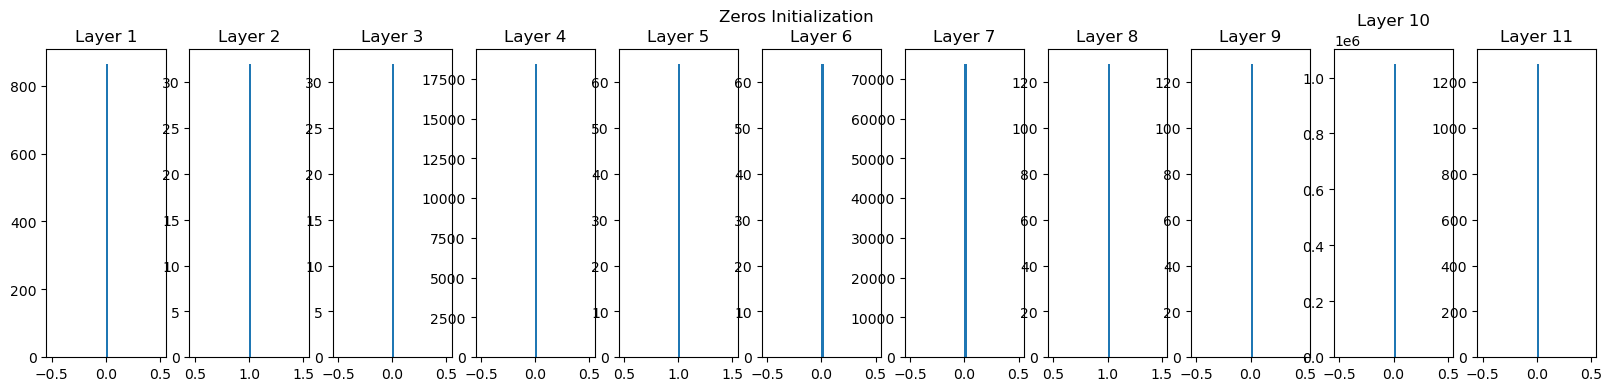

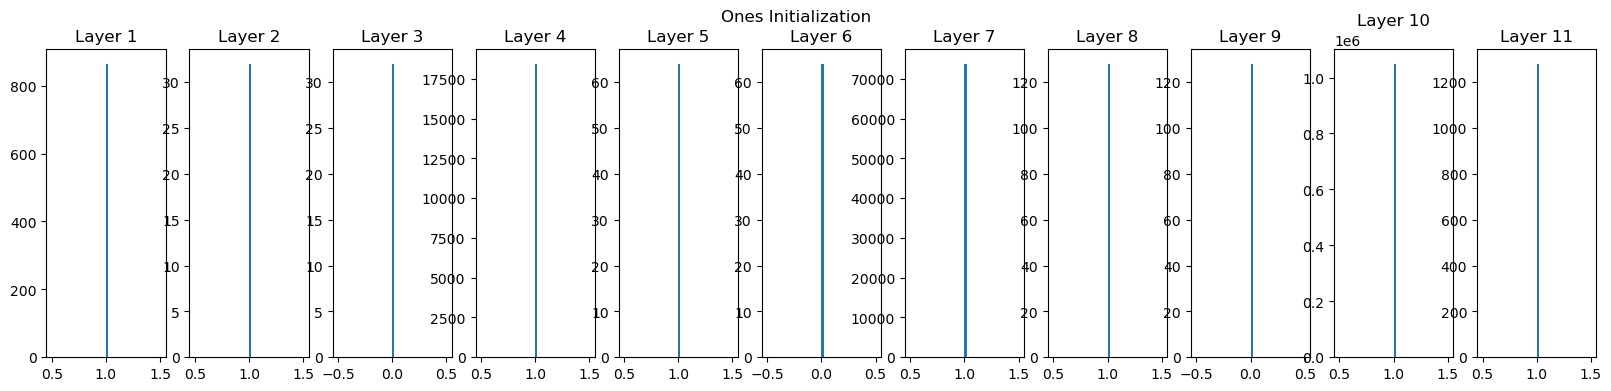

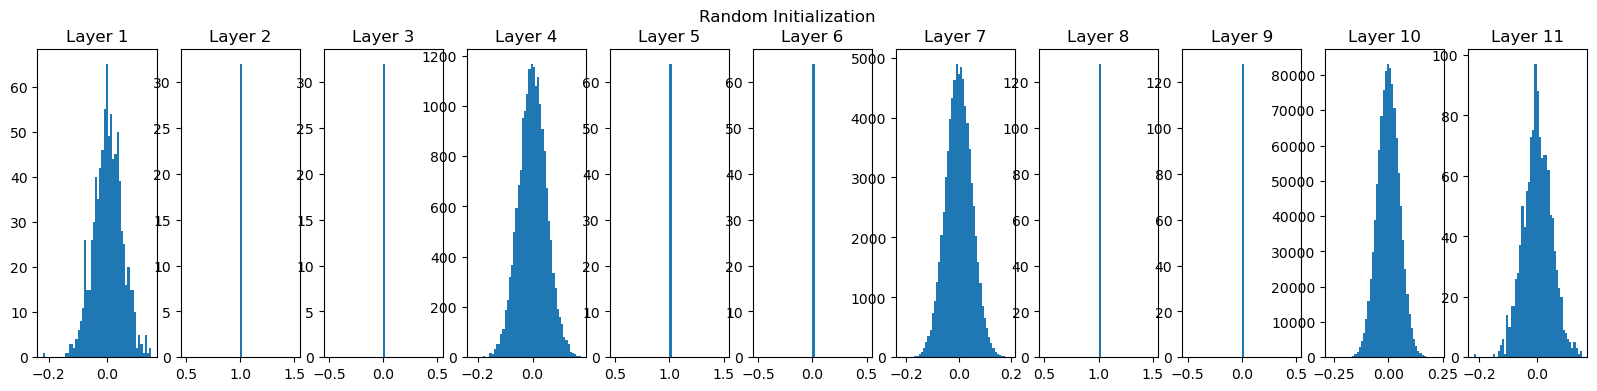

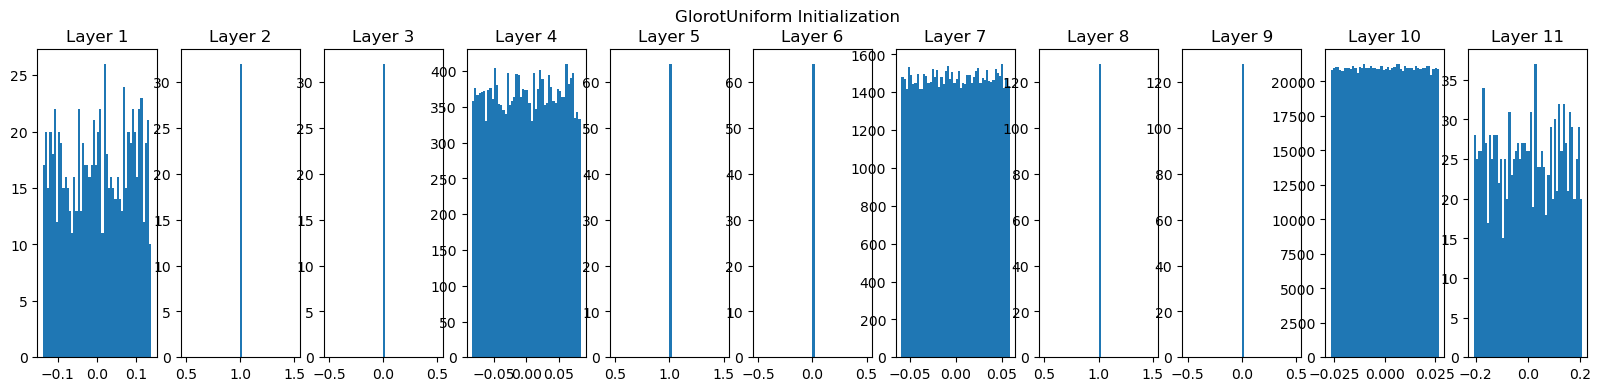

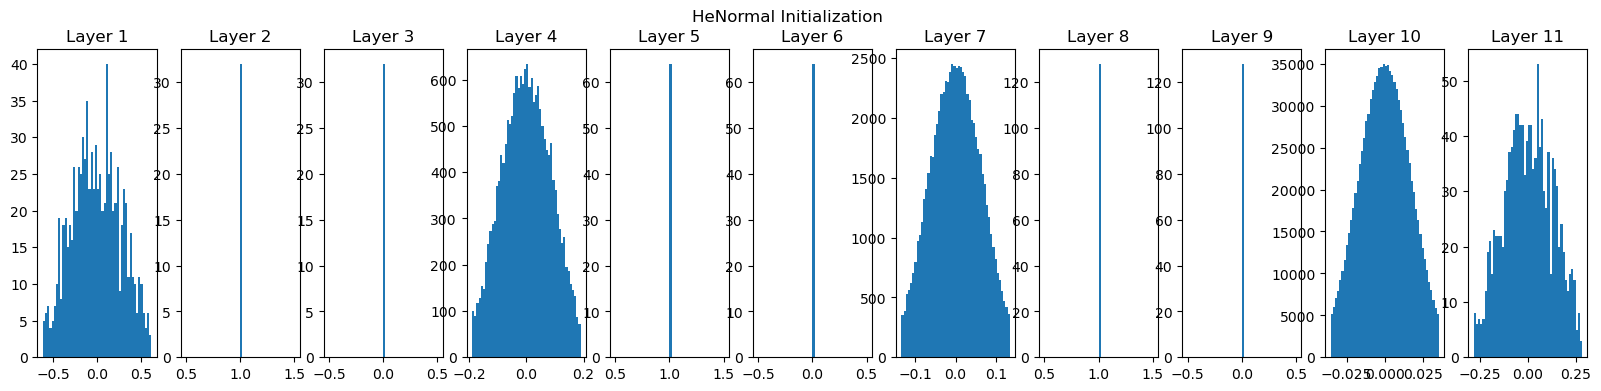

In [19]:
# TODO: Declare the following variables:
#       filters: array with the number of filters used in
#                each convolutional layer
#       k: kernel size
filters = [32,64,128]
k = 3

# Initializers
initializers = {
    'Zeros': Zeros(),
    'Ones': Ones(),
    'Random': RandomNormal(),
    'GlorotUniform': GlorotUniform(),
    'HeNormal': HeNormal()
}

# Dictionary to store the models and their initialized weights
models = {}
initial_weights = {}

for name, initializer in initializers.items():
    print(f"Initializer's Name: {name}")
    model = create_cnn(filters=filters,
                       k=k,
                       input_shape=(TARGET_SIZE,TARGET_SIZE,3),
                       n_classes=n_classes,
                       initializer=initializer)
    models[name] = model
    initial_weights[name] = model.get_weights()
    model.summary()

# Visualize initial weights for each layer in each model
for name, weights in initial_weights.items():
    num_layers = len(weights) // 2  # Since weights contain both kernels and biases
    fig, axs = plt.subplots(1, num_layers, figsize=(20, 4))
    fig.suptitle(f'{name} Initialization')
    
    for i in range(num_layers):
        kernel_weights = weights[2 * i].flatten()
        axs[i].hist(kernel_weights, bins=50)
        axs[i].set_title(f'Layer {i+1}')
    
    plt.show()

### **Model callbacks**


Define the callbacks for training:

In [11]:
cb_autosave = ModelCheckpoint("classification_model.keras",
                              mode="max",
                              save_best_only=True,
                              monitor="val_accuracy",
                              verbose=1)

cb_early_stop = EarlyStopping(patience=20,
                              verbose=1,
                              mode="auto",
                              restore_best_weights="True",
                              monitor="val_accuracy")

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="CNN for image classification",
    name="cnn-classification-euroSAT_RGB",

    # track hyperparameters and run metadata
    config={
    "architecture": "CNN",
    "dataset": "EuroSAT_RGB",
    "bs": BATCH_SIZE
    }
)

cb_wandb = WandbMetricsLogger()

callbacks = [cb_autosave, cb_early_stop, cb_wandb]

wandb: Currently logged in as: dishaghosh-applications (dishaxgh). Use `wandb login --relogin` to force relogin


## **Training the model**

In [20]:
for name, model in models.items():
    print(f"Training model with {name} initialization")
    history = model.fit(data_gen_train,
                    epochs=100,
                    validation_data=data_gen_val,
                    callbacks=callbacks
                    )
    model.save(f'model_{name}.h5')

Training model with Zeros initialization
Epoch 1/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.1126 - loss: 2.3002
Epoch 1: val_accuracy did not improve from 0.11111
507/507 ━━━━━━━━━━━━━━━━━━━━ 113s 210ms/step - accuracy: 0.1126 - loss: 2.3002 - val_accuracy: 0.1111 - val_loss: 2.2959
Epoch 2/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.1110 - loss: 2.2950
Epoch 2: val_accuracy did not improve from 0.11111
507/507 ━━━━━━━━━━━━━━━━━━━━ 100s 196ms/step - accuracy: 0.1110 - loss: 2.2950 - val_accuracy: 0.1111 - val_loss: 2.2950
Epoch 3/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.1053 - loss: 2.2950
Epoch 3: val_accuracy did not improve from 0.11111
507/507 ━━━━━━━━━━━━━━━━━━━━ 99s 195ms/step - accuracy: 0.1053 - loss: 2.2950 - val_accuracy: 0.1111 - val_loss: 2.2948
Epoch 4/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.1073 - loss: 2.2959
Epoch 4: val_accuracy did not improve from 0.11111
507/507 ━━━━━━━━━━━━━━━━━━━━ 99s 195m

Training model with Ones initialization
Epoch 1/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.1636 - loss: 177.1016
Epoch 1: val_accuracy improved from 0.11111 to 0.11130, saving model to classification_model.keras
507/507 ━━━━━━━━━━━━━━━━━━━━ 108s 201ms/step - accuracy: 0.1636 - loss: 177.0196 - val_accuracy: 0.1113 - val_loss: 2.3012
Epoch 2/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.1265 - loss: 19.1461
Epoch 2: val_accuracy did not improve from 0.11130
507/507 ━━━━━━━━━━━━━━━━━━━━ 101s 198ms/step - accuracy: 0.1265 - loss: 19.1246 - val_accuracy: 0.1111 - val_loss: 2.2969
Epoch 3/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.1136 - loss: 2.3764
Epoch 3: val_accuracy did not improve from 0.11130
507/507 ━━━━━━━━━━━━━━━━━━━━ 101s 198ms/step - accuracy: 0.1136 - loss: 2.3763 - val_accuracy: 0.1111 - val_loss: 2.2952
Epoch 4/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.1064 - loss: 2.2992
Epoch 4: val_accuracy did not impr

Training model with Random initialization
Epoch 1/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4512 - loss: 1.7698
Epoch 1: val_accuracy improved from 0.11130 to 0.19130, saving model to classification_model.keras
507/507 ━━━━━━━━━━━━━━━━━━━━ 85s 159ms/step - accuracy: 0.4513 - loss: 1.7690 - val_accuracy: 0.1913 - val_loss: 7.0771
Epoch 2/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6298 - loss: 1.0418
Epoch 2: val_accuracy improved from 0.19130 to 0.69815, saving model to classification_model.keras
507/507 ━━━━━━━━━━━━━━━━━━━━ 80s 157ms/step - accuracy: 0.6298 - loss: 1.0418 - val_accuracy: 0.6981 - val_loss: 0.9225
Epoch 3/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6879 - loss: 0.9036
Epoch 3: val_accuracy did not improve from 0.69815
507/507 ━━━━━━━━━━━━━━━━━━━━ 80s 157ms/step - accuracy: 0.6879 - loss: 0.9036 - val_accuracy: 0.5696 - val_loss: 1.1861
Epoch 4/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7161 - loss: 

Epoch 50/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9758 - loss: 0.0857
Epoch 50: val_accuracy did not improve from 0.88722
507/507 ━━━━━━━━━━━━━━━━━━━━ 93s 184ms/step - accuracy: 0.9758 - loss: 0.0856 - val_accuracy: 0.8843 - val_loss: 0.6637
Epoch 51/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9768 - loss: 0.0771
Epoch 51: val_accuracy did not improve from 0.88722
507/507 ━━━━━━━━━━━━━━━━━━━━ 91s 180ms/step - accuracy: 0.9768 - loss: 0.0771 - val_accuracy: 0.7872 - val_loss: 1.3794
Epoch 52/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9746 - loss: 0.0767
Epoch 52: val_accuracy did not improve from 0.88722
507/507 ━━━━━━━━━━━━━━━━━━━━ 90s 176ms/step - accuracy: 0.9746 - loss: 0.0767 - val_accuracy: 0.8626 - val_loss: 0.6875
Epoch 53/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9793 - loss: 0.0671
Epoch 53: val_accuracy did not improve from 0.88722
507/507 ━━━━━━━━━━━━━━━━━━━━ 104s 205ms/step - accuracy: 0.9793 - loss: 

507/507 ━━━━━━━━━━━━━━━━━━━━ 74s 146ms/step - accuracy: 0.9817 - loss: 0.0711 - val_accuracy: 0.8311 - val_loss: 1.1842
Epoch 75/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9830 - loss: 0.0630
Epoch 75: val_accuracy did not improve from 0.90796
507/507 ━━━━━━━━━━━━━━━━━━━━ 74s 145ms/step - accuracy: 0.9830 - loss: 0.0630 - val_accuracy: 0.8693 - val_loss: 0.9476
Epoch 76/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9833 - loss: 0.0562
Epoch 76: val_accuracy did not improve from 0.90796
507/507 ━━━━━━━━━━━━━━━━━━━━ 74s 145ms/step - accuracy: 0.9833 - loss: 0.0562 - val_accuracy: 0.8785 - val_loss: 0.8002
Epoch 77/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9869 - loss: 0.0464
Epoch 77: val_accuracy did not improve from 0.90796
507/507 ━━━━━━━━━━━━━━━━━━━━ 74s 146ms/step - accuracy: 0.9869 - loss: 0.0464 - val_accuracy: 0.8500 - val_loss: 1.3497
Epoch 78/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9838 - loss: 0.0483
Epoc

Training model with GlorotUniform initialization
Epoch 1/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.3823 - loss: 2.0131
Epoch 1: val_accuracy did not improve from 0.90796
507/507 ━━━━━━━━━━━━━━━━━━━━ 108s 201ms/step - accuracy: 0.3824 - loss: 2.0123 - val_accuracy: 0.1517 - val_loss: 10.5541
Epoch 2/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5409 - loss: 1.3061
Epoch 2: val_accuracy did not improve from 0.90796
507/507 ━━━━━━━━━━━━━━━━━━━━ 102s 201ms/step - accuracy: 0.5409 - loss: 1.3060 - val_accuracy: 0.4863 - val_loss: 1.8659
Epoch 3/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.5971 - loss: 1.1096
Epoch 3: val_accuracy did not improve from 0.90796
507/507 ━━━━━━━━━━━━━━━━━━━━ 110s 217ms/step - accuracy: 0.5972 - loss: 1.1096 - val_accuracy: 0.3796 - val_loss: 3.2634
Epoch 4/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6538 - loss: 0.9721
Epoch 4: val_accuracy did not improve from 0.90796
507/507 ━━━━━━━━━━━━━━━━━━━

Training model with HeNormal initialization
Epoch 1/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.4342 - loss: 1.8763
Epoch 1: val_accuracy did not improve from 0.90796
507/507 ━━━━━━━━━━━━━━━━━━━━ 110s 202ms/step - accuracy: 0.4343 - loss: 1.8755 - val_accuracy: 0.4806 - val_loss: 1.5814
Epoch 2/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6171 - loss: 1.0818
Epoch 2: val_accuracy did not improve from 0.90796
507/507 ━━━━━━━━━━━━━━━━━━━━ 102s 201ms/step - accuracy: 0.6171 - loss: 1.0818 - val_accuracy: 0.4726 - val_loss: 2.4126
Epoch 3/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6736 - loss: 0.9189
Epoch 3: val_accuracy did not improve from 0.90796
507/507 ━━━━━━━━━━━━━━━━━━━━ 86s 170ms/step - accuracy: 0.6736 - loss: 0.9189 - val_accuracy: 0.4804 - val_loss: 2.1548
Epoch 4/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7027 - loss: 0.8609
Epoch 4: val_accuracy did not improve from 0.90796
507/507 ━━━━━━━━━━━━━━━━━━━━ 76s 1

Link to the report: https://api.wandb.ai/links/dishaxgh/bqyucf77

## **Testing the model**

Test your model and report the accuracies for the train, validation and test sets.

In [21]:
data_gen_test = DataGenerator(path_images=x_test,
                              labels=y_test,
                              batch_size=BATCH_SIZE,
                              n_classes=n_classes,
                              target_size=TARGET_SIZE,
                              shuffle=False)

print("Train:")
scores_train = model.evaluate(data_gen_train)
print("Validation:")
scores_val = model.evaluate(data_gen_val)
print("Test:")
scores_test = model.evaluate(data_gen_test)

Train:
507/507 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.5022 - loss: 1.4908
Validation:
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.4772 - loss: 1.6107
Test:
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 394ms/step - accuracy: 0.4891 - loss: 1.5496
